In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

In [2]:
dataset = pd.read_csv("../data/processed/features_for_model.csv")
dataset.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,360,0,0,5849,0.0,146.412162,360.0,1.0,202,1
1,1,1,102,0,0,4583,1508.0,128.000000,360.0,1.0,179,0
2,1,1,360,0,1,3000,0.0,66.000000,360.0,1.0,202,1
3,1,1,360,1,0,2583,2358.0,120.000000,360.0,1.0,202,1
4,1,0,360,0,0,6000,0.0,141.000000,360.0,1.0,202,1


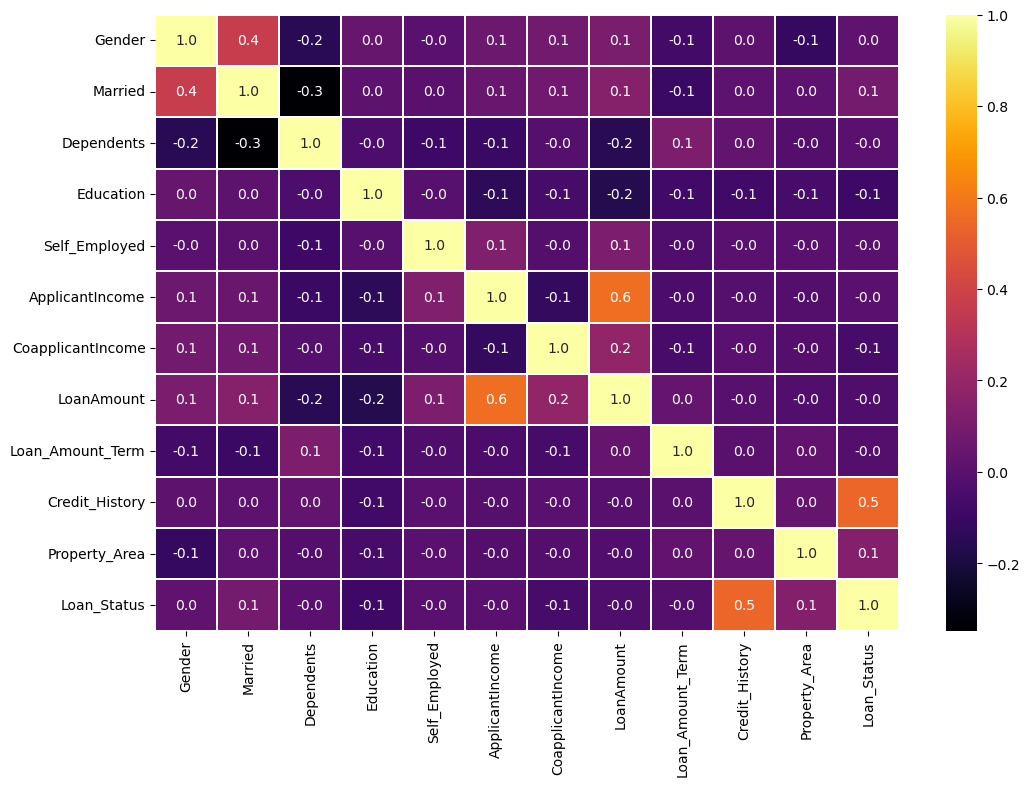

In [3]:
plt.figure(figsize=(12,8))
sns.heatmap(dataset.corr(), cmap='inferno', annot=True, fmt='.1f', linewidths=.1)
plt.show()

Seleccion de Target y Features

In [4]:
X = dataset.drop(["Loan_Status"], axis=1)
y = dataset["Loan_Status"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle=True,random_state=2025)

Configuramos y calculamos el StandarScaler

In [6]:
std_scaler = StandardScaler()
std_scaler.fit(X_train) # Calcular los valores para el scaler

StandardScaler()

Guardamos el scaler configurado (con datos de train) como artefacto del modelo.

In [7]:
import pickle

with open("../artifacts/std_scaler.pkl","wb") as f:
    pickle.dump(std_scaler,f)

## Creamos modelos de Prediccion

Modelo Regresión Logistica

In [8]:
X_train_std = std_scaler.transform(X_train)

modelo_rl = LogisticRegression()
modelo_rl.fit(X_train_std, y_train)


LogisticRegression()

Medimos el Performance

In [9]:
X_test_std = std_scaler.transform(X_test)

y_preds_rf = modelo_rl.predict(X_test_std)

accuracy_score(y_test,y_preds_rf)

0.7621621621621621

### SVM 

In [ ]:
modelo_svm = SVC()

# Hiperparámetros
param_grid_svm = [
    {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']},
    {'C': [0.1, 1, 10], 'kernel': ['linear']},
    {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1], 'kernel': ['poly'], 'degree': [2, 3]}
]


grid_search_svm = GridSearchCV(estimator=modelo_svm, param_grid=param_grid_svm,
                                 scoring='accuracy', cv=5)
grid_search_svm.fit(X_train_std, y_train)

# Mejor configuración
print(f"Mejores parámetros para SVM: {grid_search_svm.best_params_}")
print(f"Mejor precisión: {grid_search_svm.best_score_:.2f}")

Mejores parámetros para SVM: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor precisión: 0.83


c:\Users\Marvin\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Red Neuronal

In [ ]:
def crear_modelo(neuronas=32):
    modelo = Sequential()
    modelo.add(Dense(neuronas, activation='relu', input_shape=(X_train_std.shape[1],)))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(neuronas // 2, activation='relu'))
    modelo.add(Dense(1, activation='sigmoid'))
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return modelo

# Crear un clasificador Keras
modelo_nn = KerasClassifier(model=crear_modelo)

# Definir el espacio de búsqueda para los hiperparámetros
param_grid_nn = {
    'model__neuronas': [32, 64],   
    'batch_size': [16, 32],        
    'epochs': [50]            

# Búsqueda en cuadrícula
grid_search_nn = GridSearchCV(estimator=modelo_nn, param_grid=param_grid_nn,
                               scoring='accuracy', cv=3)

# Ajustar el modelo 
grid_search_nn.fit(X_train_std, y_train)

# Mejor configuración
print(f"Mejores parámetros para la Red Neuronal: {grid_search_nn.best_params_}")
print(f"Mejor precisión: {grid_search_nn.best_score_:.2f}")

Epoch 1/50


c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6122 - loss: 0.6628
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6045 - loss: 0.6622 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6558 - loss: 0.6379 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7226 - loss: 0.6070 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7088 - loss: 0.5677 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7263 - loss: 0.5959 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7728 - loss: 0.5120 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7630 - loss: 0.5497 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.5357 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7611 - loss: 0.5481 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8102 - loss: 0.5038 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - los

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6129 - loss: 0.6753
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7060 - loss: 0.6481 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7257 - loss: 0.6247 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7088 - loss: 0.6232 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6944 - loss: 0.6146 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6874 - loss: 0.6257 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6993 - loss: 0.5794 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7078 - loss: 0.6409 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7236 - loss: 0.5757 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7149 - loss: 0.5744 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7249 - loss: 0.5603 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6916 - los

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4245 - loss: 0.7573
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4674 - loss: 0.7709
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6074 - loss: 0.6637 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6877 - loss: 0.6242 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7375 - loss: 0.6087 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7282 - loss: 0.6501 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8024 - loss: 0.5625 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7524 - loss: 0.5752 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7555 - loss: 0.5511 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7616 - loss: 0.5566 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.4883 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7926 - loss

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6673 - loss: 0.6612
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6788 - loss: 0.6381 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6869 - loss: 0.6154 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7764 - loss: 0.5410 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7516 - loss: 0.5553 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7915 - loss: 0.4961 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8218 - loss: 0.4636 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7859 - loss: 0.5032 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8117 - loss: 0.4420 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8287 - loss: 0.4565
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8116 - loss: 0.4685 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4530 - loss: 0.7226
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6868 - loss: 0.6408 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7496 - loss: 0.6059 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7359 - loss: 0.6050 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7832 - loss: 0.5494 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7832 - loss: 0.5449 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7699 - loss: 0.5011 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8148 - loss: 0.4670 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8017 - loss: 0.5054 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7963 - loss: 0.4983 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7764 - loss: 0.5003 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8103 - los

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6912 - loss: 0.6661
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6981 - loss: 0.6239 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6633 - loss: 0.6438 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - loss: 0.4943 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7973 - loss: 0.5267 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7712 - loss: 0.5056 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7903 - loss: 0.5032 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8277 - loss: 0.4767 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8039 - loss: 0.4718 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8537 - loss: 0.4325 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.4311  
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8232 - lo

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6799 - loss: 0.6740
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6955 - loss: 0.6621 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7118 - loss: 0.6361 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6649 - loss: 0.6443  
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7065 - loss: 0.6585 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7092 - loss: 0.6224 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7054 - loss: 0.6128 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7172 - loss: 0.6134 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7038 - loss: 0.6340 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7062 - loss: 0.6421 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7178 - loss: 0.5994 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7563 - loss: 0.5687 
Epoch 13/50


c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5789 - loss: 0.7035
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6351 - loss: 0.6533 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6592 - loss: 0.6934 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6968 - loss: 0.6039 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7067 - loss: 0.6285 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7352 - loss: 0.5688 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7300 - loss: 0.5770 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8000 - loss: 0.5364 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7370 - loss: 0.6141
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7339 - loss: 0.5783 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7777 - loss: 0.5336 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7401 - loss: 0.5539 
Epoch 13/50
9/

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4069 - loss: 0.8216
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4758 - loss: 0.7814 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6060 - loss: 0.6754 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6068 - loss: 0.6591 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6270 - loss: 0.6524 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7473 - loss: 0.5966 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7227 - loss: 0.6089 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6967 - loss: 0.6202 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7713 - loss: 0.5783 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8131 - loss: 0.5466 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7807 - loss: 0.5486 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7648 - loss: 0.5642 
Epoch 13/50
9

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5428 - loss: 0.7096
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5766 - loss: 0.6791 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7393 - loss: 0.6170 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7605 - loss: 0.5695 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8005 - loss: 0.5462 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7880 - loss: 0.5350 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7577 - loss: 0.5522 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7931 - loss: 0.5065 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8312 - loss: 0.5160 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8194 - loss: 0.4634 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8120 - loss: 0.4658 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7862 - loss: 0.5126 
Epoch 13/50
9

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5492 - loss: 0.7006
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7112 - loss: 0.6193 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7441 - loss: 0.6062 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7506 - loss: 0.5829 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7535 - loss: 0.5776 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7496 - loss: 0.5191 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7773 - loss: 0.5014 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8073 - loss: 0.5071 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7880 - loss: 0.5208 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7970 - loss: 0.4805 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7556 - loss: 0.5373 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8248 - loss: 0.4606 
Epoch 13/50
9

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6373 - loss: 0.7309
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6135 - loss: 0.7057 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7131 - loss: 0.6280 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7538 - loss: 0.5998 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7204 - loss: 0.5976 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7390 - loss: 0.5816 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7364 - loss: 0.5845 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7906 - loss: 0.5379 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7592 - loss: 0.5269 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.4870 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7948 - loss: 0.4852 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8019 - loss: 0.4949 
Epoch 13/50
9

c:\Users\Marvin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7003 - loss: 0.6575
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7002 - loss: 0.6647 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7053 - loss: 0.6143 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7287 - loss: 0.6150 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7221 - loss: 0.5986 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7555 - loss: 0.5831 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7716 - loss: 0.5474 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7890 - loss: 0.5551 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7438 - loss: 0.5755 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7780 - loss: 0.5357 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7749 - loss: 0.5275 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7854 - los